In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
from pennylane import numpy as np
import matplotlib.pyplot as plt
import pennylane as qml
import torch

# 1º: Constructing The Samples Of Internuclear Distances And calculating the Hartree-Fock energies

The main idea behind this Jupyter notebook is to calculate the ground state energy for different internuclear distances. We will do this using the restricted Hartree-Fock method (computationally cheap to simulate) and the noise-free VQE algorithm (computationally difficult to simulate).

The two code cells below focus only on creating the samples that we will use as the internuclear distance and using the restricted Hartree-Fock method to calculate the ground state energy.

In [3]:
radius =[round(x * 0.01, 4) for x in range(25,400)]

In [4]:
hf_gs_h2 = []

for i, r in enumerate(radius): 
    symbols  = ['H', 'H']
    coordinates = np.array([[0.0, 0.0, 0], [0.0, 0.0, r]], requires_grad = False)
    H2_molecule = qml.qchem.Molecule(symbols, coordinates, basis_name='STO-3G', load_data=True, unit='bohr')
    args = H2_molecule.alpha.copy()
    ground_state_en = qml.qchem.hf_energy(H2_molecule)(*args)

    print(f"{i+1} - Estimated Energy and Parameter for Radius {r} a.u: {ground_state_en} ha")
    hf_gs_h2.append([r,float(ground_state_en)])

1 - Estimated Energy and Parameter for Radius 0.25 a.u: 1.4494427533879728 ha
2 - Estimated Energy and Parameter for Radius 0.26 a.u: 1.300273333970198 ha
3 - Estimated Energy and Parameter for Radius 0.27 a.u: 1.1626360868994023 ha
4 - Estimated Energy and Parameter for Radius 0.28 a.u: 1.03530539564487 ha
5 - Estimated Energy and Parameter for Radius 0.29 a.u: 0.9172240222432486 ha
6 - Estimated Energy and Parameter for Radius 0.3 a.u: 0.8074750493343159 ha
7 - Estimated Energy and Parameter for Radius 0.31 a.u: 0.7052592546575291 ha
8 - Estimated Energy and Parameter for Radius 0.32 a.u: 0.6098767295666692 ha
9 - Estimated Energy and Parameter for Radius 0.33 a.u: 0.5207118412207721 ha
10 - Estimated Energy and Parameter for Radius 0.34 a.u: 0.4372208499492962 ha
11 - Estimated Energy and Parameter for Radius 0.35 a.u: 0.3589216506569106 ha
12 - Estimated Energy and Parameter for Radius 0.36 a.u: 0.28538522515981324 ha
13 - Estimated Energy and Parameter for Radius 0.37 a.u: 0.21622

# 2º: Constructing the internuclear distance samples and calculating the energies with VQE

This time, we will use VQE to calculate the ground state energies. We will use a noise-free simulator with the L-BFGS optimizer. This time, we will reduce the number of internuclear samples to speed up the calculation. The VQE calculation for different internuclear distances can take from 40 minutes to 1 hour.

In [5]:
qubits = 4
radius =[round(x * 0.1, 4) for x in range(3, 41)]
hf_jw = qml.qchem.hf_state(electrons=2, orbitals=qubits)

In [6]:
dev = qml.device("qiskit.aer", wires=4, backend='statevector_simulator',shots=None)

In [7]:
@qml.qnode(dev, interface="pytorch")
def circuit(param, wires, U):
    qml.BasisState(hf_jw, wires=wires)
    qml.DoubleExcitation(param[0], wires=[0, 1, 2, 3])
    return qml.expval(U)

def cost_fn(param, U):
        return circuit(param, range(qubits), U)

In [8]:
theta = torch.nn.Parameter(torch.tensor([0.0]))
optimizer = torch.optim.LBFGS([theta], lr=0.05, max_iter=250, tolerance_grad=1e-8)

In [9]:
VQE_gs_h2 = []

for i, r in enumerate(radius): 
    symbols = ["H", "H"]
    coordinates = np.array([[0.0, 0.0, 0], [0.0, 0.0, r]], requires_grad = False)
    molecule = qml.qchem.Molecule(symbols, coordinates, basis_name='STO-3G', load_data=True, unit='bohr')
    H, qubits = qml.qchem.molecular_hamiltonian(molecule)
    
    def closure():
        optimizer.zero_grad()
        loss = cost_fn(theta, H)
        loss.backward()
        return loss

    optimizer.step(closure)

    print(f"{i+1} - Estimated Energy and Parameter for Radius {r} a.u: {cost_fn(theta, H).item()}; {theta.detach().numpy()} a.u")
    VQE_gs_h2.append([r, cost_fn(theta, H).item()])

1 - Estimated Energy and Parameter for Radius 0.3 a.u: 0.8011605264496588; [0.08025225] a.u
2 - Estimated Energy and Parameter for Radius 0.4 a.u: 0.024958194566761627; [0.08598849] a.u
3 - Estimated Energy and Parameter for Radius 0.5 a.u: -0.4107884596454825; [0.0932807] a.u
4 - Estimated Energy and Parameter for Radius 0.6 a.u: -0.6765108002248228; [0.10208629] a.u
5 - Estimated Energy and Parameter for Radius 0.7 a.u: -0.8463259745114439; [0.11236488] a.u
6 - Estimated Energy and Parameter for Radius 0.8 a.u: -0.9575985217796901; [0.12409546] a.u
7 - Estimated Energy and Parameter for Radius 0.9 a.u: -1.0310430170077152; [0.1372914] a.u
8 - Estimated Energy and Parameter for Radius 1.0 a.u: -1.0789697597816499; [0.1519554] a.u
9 - Estimated Energy and Parameter for Radius 1.1 a.u: -1.109137281444364; [0.16811377] a.u
10 - Estimated Energy and Parameter for Radius 1.2 a.u: -1.126698812703856; [0.18578622] a.u
11 - Estimated Energy and Parameter for Radius 1.3 a.u: -1.135227923561859

# 3º: Analyzing The Results

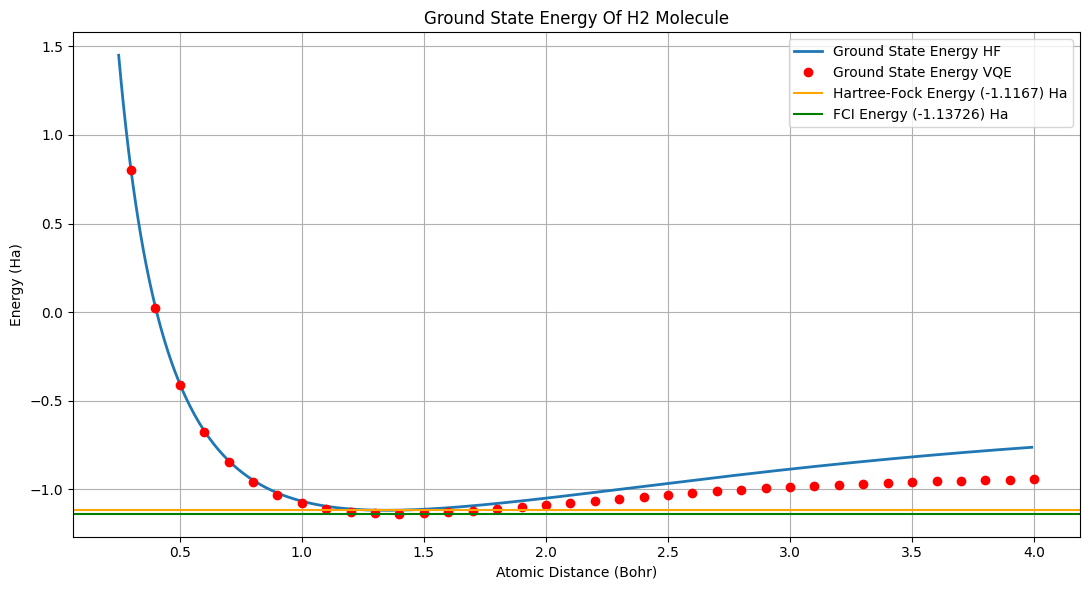

In [11]:
hf_energy = -1.1167
fci_energy = -1.13726

hf_gs_h2 = np.array(hf_gs_h2)
VQE_gs_h2 = np.array(VQE_gs_h2)

x1 = hf_gs_h2[:, 0]
y1 = hf_gs_h2[:, 1]
x2 = VQE_gs_h2[:, 0]
y2 = VQE_gs_h2[:, 1]  

plt.figure(figsize=(11, 6))
plt.plot(x1, y1, linestyle='-', linewidth=2, label='Ground State Energy HF')
plt.plot(x2, y2, color='red', marker='o', linestyle=None, linewidth=0, label='Ground State Energy VQE')
plt.axhline(hf_energy, color='orange', linestyle='-', label=f'Hartree-Fock Energy ({hf_energy}) Ha')
plt.axhline(fci_energy, color='green', linestyle='-', label=f'FCI Energy ({fci_energy}) Ha')
plt.xlabel('Atomic Distance (Bohr)')
plt.ylabel('Energy (Ha)')
plt.title('Ground State Energy Of H2 Molecule')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
